# 다음에 볼 영화 예측하기 - Movielens 영화 SBR
- Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

In [1]:
import tensorflow as tf
import datetime as dt
from pathlib import Path
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

## Step 0. 데이터 준비하기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


## Step 1. 데이터의 전처리
- 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
- 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [3]:
# UTC 형식으로 되어있는 시간 데이터를 바꿔주기
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [4]:
# 유저 수와 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- 총 6040명의 유저와, 3706개의 아이템이 있다.

In [5]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

- 각 유저들이 얼마나 영화를 봤는지 확인!

In [6]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

- 중간값은 96, 평균은 165.   
- 평균적으로 유저 한명은 165편의 영화를 봤다.

In [7]:
user_length.min(), user_length.max()

(20, 2314)

In [8]:
user_length.quantile(0.999)

1343.181000000005

In [9]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

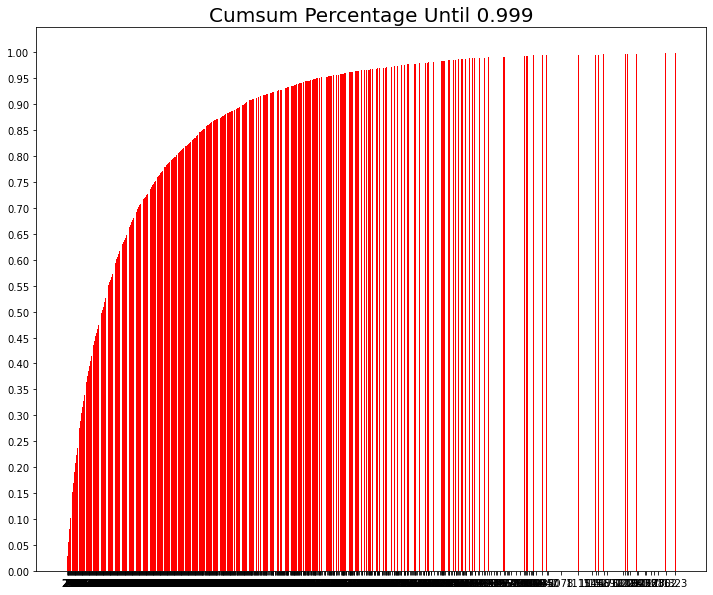

In [10]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


- 대략 3년 정도의 데이터가 있다.

In [12]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

### Rating

- Rating은 1 ~ 5 사이의 값이다.
- Rating이 높은 것이 해당 영화가 맘에 들었다는 의미로, 다음에 볼 영화를 예측하기 위해선 Rating 값이 높은 데이터가 중요하다.
- Rating이 1~2 정도로 낮은 데이터는 필요 없다고 판단해 지워줌.

In [13]:
data['Rating'].min(), data['Rating'].max()

(1, 5)

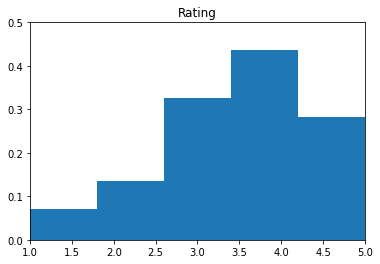

In [14]:
plt.hist(data['Rating'], density=True, bins=5)
plt.title('Rating')
plt.axis([1, 5, 0, 0.5])
plt.show()

- 히스토그램으로 시각화해서 확인해보니, rating이 1, 2인 데이터의 양이 많지 않다.
- 지워도 상관없을 것 같다.

In [15]:
data = data[data['Rating']>=3]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


- 데이터의 개수가 1000209개에서 836478개로 줄어들었다.

### Data Cleansing

In [16]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
user_len = data.groupby('UserId').size()
item_popular = data.groupby('ItemId').size()

print(user_len.mean())
print(item_popular.mean())

138.51266766020865
230.56174200661522


- 한명의 user는 평균 138편의 영화를 봤고, item은 평균 230회 시청되었다.

- 1번만 시청된 item과, 5번 이하로 시청한 user의 데이터는 제거.

In [18]:
data = cleanse_recursive(data, shortest=4, least_view=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### Train / Valid / Test split

In [19]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [20]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [21]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 819265
	 Users: 6036
	 Items: 3509
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9795
	 Users: 390
	 Items: 2372
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7298
	 Users: 333
	 Items: 2064
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [24]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성
- 실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다.
- Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.

### SessionDataset

In [25]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [26]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [27]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 818870, 818989, 819265], dtype=int32)

In [28]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6033, 6034, 6035])

### SessionDataLoader

In [29]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [30]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head

<bound method NDFrame.head of          UserId  ItemId  Rating                Time  item_idx
31            1    3186       4 2000-12-31 22:00:19         0
22            1    1270       5 2000-12-31 22:00:55         1
27            1    1721       4 2000-12-31 22:00:55         2
37            1    1022       5 2000-12-31 22:00:55         3
24            1    2340       3 2000-12-31 22:01:43         4
...         ...     ...     ...                 ...       ...
1000019    6040    2917       4 2001-08-10 14:40:29      1104
999988     6040    1921       4 2001-08-10 14:41:04       315
1000172    6040    1784       3 2001-08-10 14:41:04        87
1000167    6040     161       3 2001-08-10 14:41:26       410
1000042    6040    1221       4 2001-08-20 13:44:15       371

[819265 rows x 5 columns]>

In [31]:
iter_ex = iter(tr_data_loader)

In [32]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성

In [33]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [36]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [37]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

---

## Step 4. 모델 학습

- batch_size=256
- hsz=50
- drop_rate=0.1
- lr=0.001
- epochs=5
- k=20

In [38]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3509)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    534150    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3509)               178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  17%|█▋        | 6/36 [00:08<00:44,  1.50s/it]


	 - Recall@20 epoch 1: 0.057292
	 - MRR@20    epoch 1: 0.011176



Evaluation:  17%|█▋        | 6/36 [00:08<00:41,  1.40s/it]


	 - Recall@20 epoch 2: 0.093750
	 - MRR@20    epoch 2: 0.025565



Evaluation:  17%|█▋        | 6/36 [00:08<00:42,  1.40s/it]


	 - Recall@20 epoch 3: 0.110677
	 - MRR@20    epoch 3: 0.028790



Evaluation:  17%|█▋        | 6/36 [00:08<00:41,  1.38s/it]


	 - Recall@20 epoch 4: 0.113281
	 - MRR@20    epoch 4: 0.031435



Evaluation:  17%|█▋        | 6/36 [00:08<00:42,  1.43s/it]

	 - Recall@20 epoch 5: 0.113932
	 - MRR@20    epoch 5: 0.032305



---

## Step 5. 모델 테스트

In [39]:
test_model(model, args, test)

Evaluation:   7%|▋         | 2/27 [00:02<00:36,  1.46s/it]

	 - Recall@20: 0.117188
	 - MRR@20: 0.035188



---

## Step 6. 하이퍼 파라미터 변경

### Batch size 조절

- **batch_size=128**
- hsz=50
- drop_rate=0.1
- lr=0.001
- epochs=5
- k=20

In [41]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3509)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    534150    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3509)               178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  48%|████▊     | 35/73 [00:25<00:27,  1.39it/s]


	 - Recall@20 epoch 1: 0.095312
	 - MRR@20    epoch 1: 0.023695



Evaluation:  48%|████▊     | 35/73 [00:25<00:27,  1.37it/s]


	 - Recall@20 epoch 2: 0.114509
	 - MRR@20    epoch 2: 0.030899



Evaluation:  48%|████▊     | 35/73 [00:25<00:27,  1.39it/s]


	 - Recall@20 epoch 3: 0.125446
	 - MRR@20    epoch 3: 0.033803



Evaluation:  48%|████▊     | 35/73 [00:25<00:27,  1.39it/s]


	 - Recall@20 epoch 4: 0.129241
	 - MRR@20    epoch 4: 0.035145



Evaluation:  48%|████▊     | 35/73 [00:24<00:26,  1.42it/s]

	 - Recall@20 epoch 5: 0.133929
	 - MRR@20    epoch 5: 0.038040



In [42]:
test_model(model2, args2, test)

Evaluation:  37%|███▋      | 20/54 [00:14<00:24,  1.41it/s]

	 - Recall@20: 0.141797
	 - MRR@20: 0.039571



---
- batch_size=512는 배치사이즈가 너무 커서 에러가 나는것 같다..   
---
- **batch_size=64**
- hsz=50
- drop_rate=0.1
- lr=0.001
- epochs=5
- k=20

In [39]:
args3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3509)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      534150    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3509)                178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 105/146 [00:38<00:15,  2.71it/s]


	 - Recall@20 epoch 1: 0.107738
	 - MRR@20    epoch 1: 0.027092



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.82it/s]


	 - Recall@20 epoch 2: 0.124107
	 - MRR@20    epoch 2: 0.033736



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.83it/s]


	 - Recall@20 epoch 3: 0.134375
	 - MRR@20    epoch 3: 0.037171



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.82it/s]


	 - Recall@20 epoch 4: 0.133631
	 - MRR@20    epoch 4: 0.037132



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.81it/s]

	 - Recall@20 epoch 5: 0.136607
	 - MRR@20    epoch 5: 0.038022



In [40]:
test_model(model3, args3, test)

Evaluation:  59%|█████▉    | 64/108 [00:22<00:15,  2.83it/s]

	 - Recall@20: 0.156494
	 - MRR@20: 0.044185



---
### batch size 요약

|batch size||64|128|256|
|---||---|---|---|
|Recall||0.156494|0.141797|0.117188|
|MRR||0.044185|0.039571|0.035188|

* batch size가 작아질수록 Recall과 MRR이 향상되는 것을 확인했다.
---

### Learning rate 조절

- batch_size=64
- hsz=50
- drop_rate=0.1
- **lr=0.01**
- epochs=5
- k=20

In [41]:
args4 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=5, k=20)
model4 = create_model(args4)
train_model(model4, args4)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3509)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      534150    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3509)                178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.82it/s]


	 - Recall@20 epoch 1: 0.118155
	 - MRR@20    epoch 1: 0.030824



Evaluation:  72%|███████▏  | 105/146 [00:38<00:14,  2.76it/s]


	 - Recall@20 epoch 2: 0.120536
	 - MRR@20    epoch 2: 0.031782



Evaluation:  72%|███████▏  | 105/146 [00:38<00:14,  2.76it/s]


	 - Recall@20 epoch 3: 0.117708
	 - MRR@20    epoch 3: 0.032208



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.82it/s]


	 - Recall@20 epoch 4: 0.118155
	 - MRR@20    epoch 4: 0.031581



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.83it/s]

	 - Recall@20 epoch 5: 0.118006
	 - MRR@20    epoch 5: 0.031171



In [42]:
test_model(model4, args4, test)

Evaluation:  59%|█████▉    | 64/108 [00:22<00:15,  2.83it/s]

	 - Recall@20: 0.135986
	 - MRR@20: 0.038346



---
- batch_size=64
- hsz=50
- drop_rate=0.1
- **lr=0.005**
- epochs=5
- k=20

In [43]:
args5 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.005, epochs=5, k=20)
model5 = create_model(args5)
train_model(model5, args5)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3509)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      534150    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3509)                178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 105/146 [00:38<00:14,  2.76it/s]


	 - Recall@20 epoch 1: 0.124851
	 - MRR@20    epoch 1: 0.034145



Evaluation:  72%|███████▏  | 105/146 [00:38<00:14,  2.76it/s]


	 - Recall@20 epoch 2: 0.127976
	 - MRR@20    epoch 2: 0.034729



Evaluation:  72%|███████▏  | 105/146 [00:38<00:14,  2.74it/s]


	 - Recall@20 epoch 3: 0.129167
	 - MRR@20    epoch 3: 0.035392



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.78it/s]


	 - Recall@20 epoch 4: 0.128571
	 - MRR@20    epoch 4: 0.034865



Evaluation:  72%|███████▏  | 105/146 [00:38<00:14,  2.75it/s]

	 - Recall@20 epoch 5: 0.128423
	 - MRR@20    epoch 5: 0.035945



In [44]:
test_model(model5, args5, test)

Evaluation:  59%|█████▉    | 64/108 [00:22<00:15,  2.78it/s]

	 - Recall@20: 0.144287
	 - MRR@20: 0.038317



In [45]:
args6 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0005, epochs=5, k=20)
model6 = create_model(args6)
train_model(model6, args6)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 3509)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      534150    
_________________________________________________________________
dropout_4 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (64, 3509)                178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 105/146 [00:38<00:15,  2.73it/s]


	 - Recall@20 epoch 1: 0.069792
	 - MRR@20    epoch 1: 0.015547



Evaluation:  72%|███████▏  | 105/146 [00:38<00:15,  2.71it/s]


	 - Recall@20 epoch 2: 0.101786
	 - MRR@20    epoch 2: 0.027011



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.78it/s]


	 - Recall@20 epoch 3: 0.115327
	 - MRR@20    epoch 3: 0.031036



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.77it/s]


	 - Recall@20 epoch 4: 0.122470
	 - MRR@20    epoch 4: 0.033164



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.78it/s]

	 - Recall@20 epoch 5: 0.126190
	 - MRR@20    epoch 5: 0.034843



In [46]:
test_model(model6, args6, test)

Evaluation:  59%|█████▉    | 64/108 [00:22<00:15,  2.81it/s]

	 - Recall@20: 0.147949
	 - MRR@20: 0.042064



### learning rate 요약

|learning late||0.0005|0.001|0.005|0.01|
|---||---|---|---|---|
|Recall||0.147949|0.156494|0.144287|0.135986|
|MRR||0.042064|0.044185|0.038317|0.038346|

    - 0.0005 : Recall=0.147949 MRR=0.042064
    - 0.001 : Recall=0.156494 MRR=0.044185
    - 0.005 : Recall=0.144287 MRR=0.038317
    - 0.01 : Recall=0.135986 MRR=0.038346
    
- learning rate는 낮아질수록 Recall과 MRR이 높아지는 것 같다. 하지만 0.001 밑으로 너무 낮아지면 오히려 감소한다.
- lr=0.0005로 하고 epoch를 더 늘려주면 좋아질 것 같다. 시도해본다.

#### epoch
---
- batch_size=64
- hsz=50
- drop_rate=0.1
- **lr=0.005**
- **epochs=10**
- k=20

In [47]:
args7 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0005, epochs=10, k=20)
model7 = create_model(args7)
train_model(model7, args7)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(64, 1, 3509)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      534150    
_________________________________________________________________
dropout_5 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_5 (Dense)              (64, 3509)                178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 105/146 [00:38<00:15,  2.72it/s]


	 - Recall@20 epoch 1: 0.071577
	 - MRR@20    epoch 1: 0.016015



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.78it/s]


	 - Recall@20 epoch 2: 0.109375
	 - MRR@20    epoch 2: 0.028437



Evaluation:  72%|███████▏  | 105/146 [00:39<00:15,  2.68it/s]


	 - Recall@20 epoch 3: 0.121429
	 - MRR@20    epoch 3: 0.031962



Evaluation:  72%|███████▏  | 105/146 [00:38<00:14,  2.75it/s]


	 - Recall@20 epoch 4: 0.126488
	 - MRR@20    epoch 4: 0.034394



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.78it/s]


	 - Recall@20 epoch 5: 0.132887
	 - MRR@20    epoch 5: 0.037030



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.77it/s]


	 - Recall@20 epoch 6: 0.136310
	 - MRR@20    epoch 6: 0.038110



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.80it/s]


	 - Recall@20 epoch 7: 0.138244
	 - MRR@20    epoch 7: 0.040090



Evaluation:  72%|███████▏  | 105/146 [00:36<00:14,  2.84it/s]


	 - Recall@20 epoch 8: 0.136756
	 - MRR@20    epoch 8: 0.040743



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.83it/s]


	 - Recall@20 epoch 9: 0.138542
	 - MRR@20    epoch 9: 0.042223



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.83it/s]

	 - Recall@20 epoch 10: 0.138690
	 - MRR@20    epoch 10: 0.042086



In [48]:
test_model(model7, args7, test)

Evaluation:  59%|█████▉    | 64/108 [00:22<00:15,  2.85it/s]

	 - Recall@20: 0.155762
	 - MRR@20: 0.045341



|epoch||5|10|
|---||---|---|
|Recall|| 0.147949|0.155762|
|MRR||0.042064|0.045341|

- epoch를 늘리니 예상했던대로 Recall, MRR의 수치가 올랐다.

## 회고
- 데이터에서 Rating에 대한 정보는 사용해도 되고, 무시해도 된다고 해서, rating이 1~2점인 데이터는 지우는 방식으로 사용해봤음.
- 모델 훈련을 시키면서 여러가지로 하이퍼파라메터를 수정해봤음. 하면서 느꼈던건, 이런식으로 일일히 값을 수정하면서 최적값을 찾는건 힘들겠다는 거였음.
- 이전에 배웠던 grid search 같은 걸로 찾아보는것도 해보고 싶지만 오래걸려서 못할거같아 포기했음!
- Session-Based Recommendation 개념이 어려웠다.
- batch size 조절하면서 크게 했더니 에러가 났는데, 왜 에러가 나는지 몰라서 조금 헤맸다.   
- 아지트 보니까 나랑 똑같은 상황이신 분이 계시고, 답변도 달려있길래 batch size 문제인걸 알게됐다.
- 궁금한점.. 왜 훈련이나 평가 퍼센트가 100%가 안됐는데 끝날까.